In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from dataset import SignLanguageDataset, split_tensor_dataset, read_tensor_dataset
from utils import plot_dataset
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import v2
import torch
import tqdm

from dataset import max_channel


# Load old annotated data

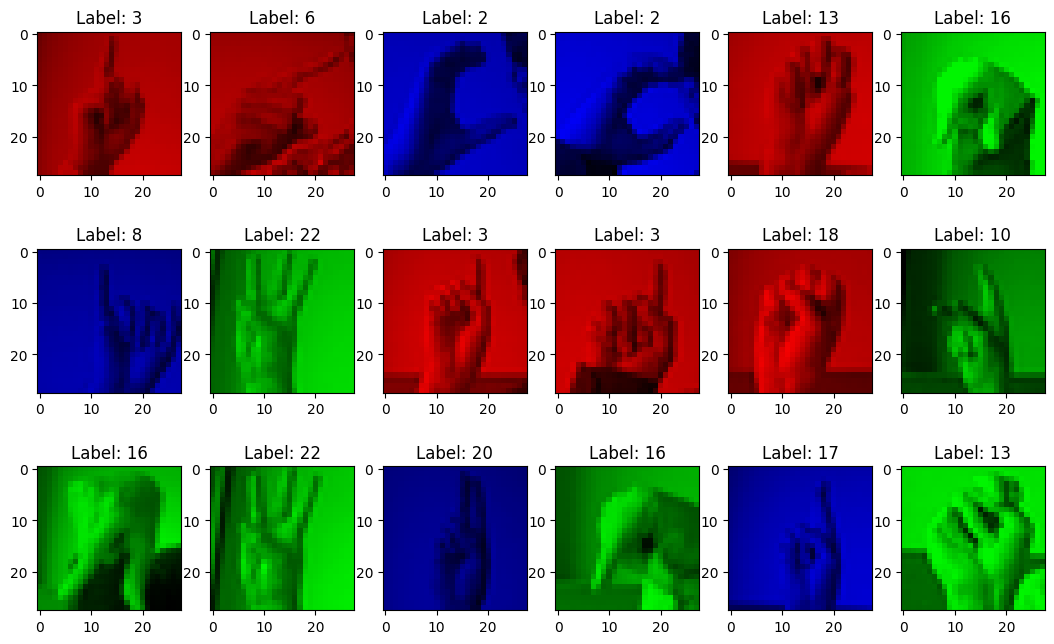

In [2]:
raw_data = read_tensor_dataset(
    "data/thws-mai-idl-ss-25-sign-language/SignLanguage_kaggle/old_annotated.pth")

plot_dataset(raw_data)

Train data lenght: 19218
Val data lenght: 4118
Test data lenght: 4119
torch.Size([1, 1, 128, 128])


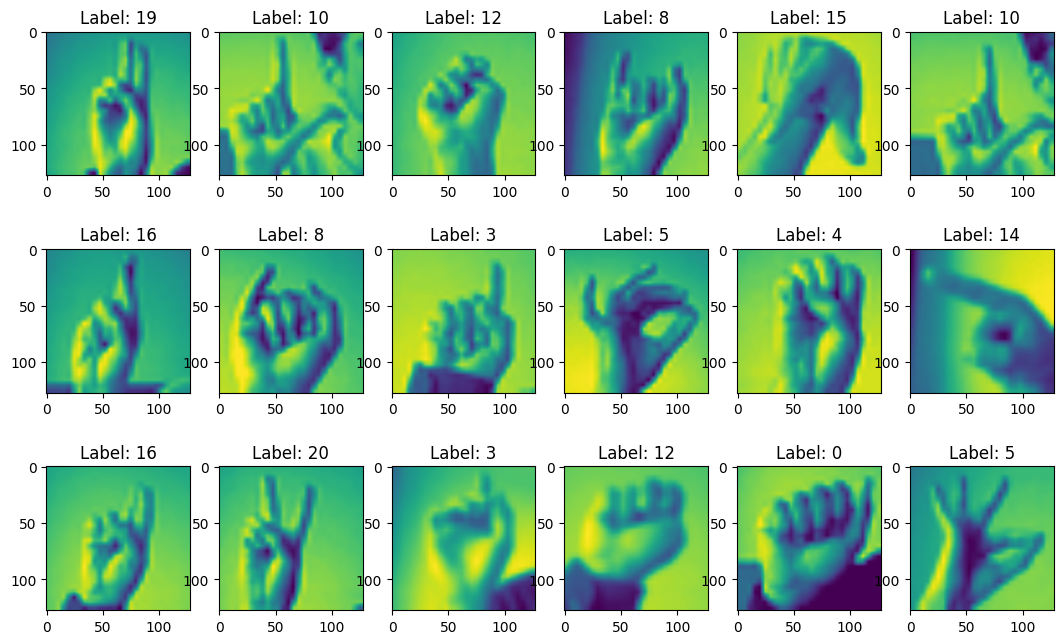

In [ ]:
IMAGE_SIZE = 128
train_data, val_data, test_data = split_tensor_dataset(raw_data)

print(f"Train data lenght: {len(train_data)}")
print(f"Val data lenght: {len(val_data)}")
print(f"Test data lenght: {len(test_data)}")

transform = v2.Compose(
    [
        v2.Lambda(max_channel),
        v2.Lambda(lambda x: 1-x),
        v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    ]
)

train_dataset = SignLanguageDataset(train_data, transform=transform)

train_dataloader = iter(DataLoader(
    train_dataset, batch_size=1, shuffle=True))
# print(next(train_dataloader))
img, label = next(train_dataloader)
print(img.shape)

plot_dataset(train_dataloader)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


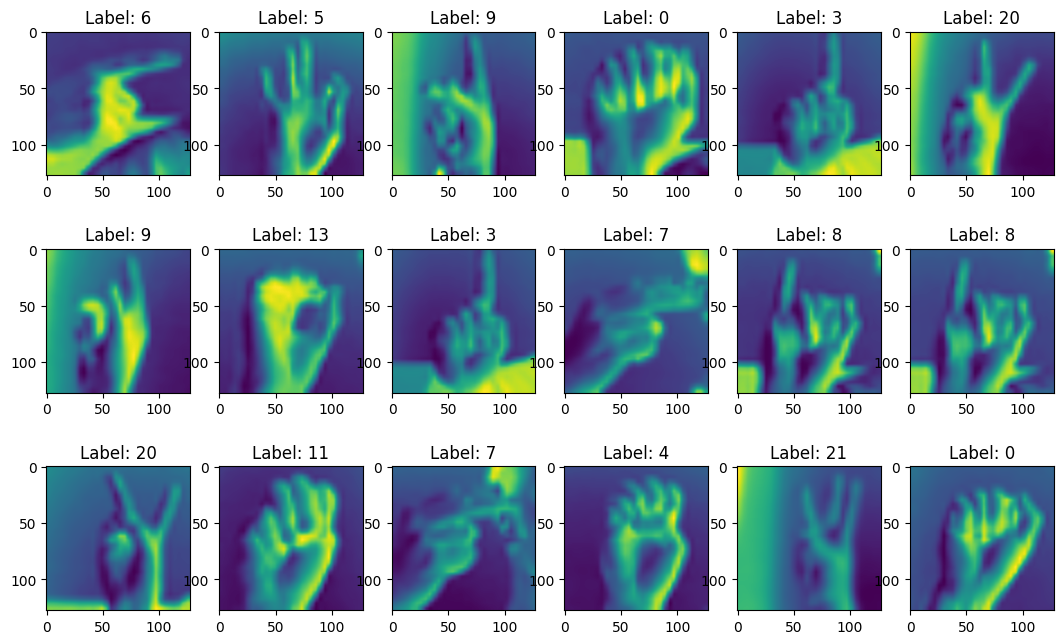

In [33]:
# Read todoexample, make sure the l"abels also didn't include 9
todo_example = read_tensor_dataset(
    "data/thws-mai-idl-ss-25-sign-language/SignLanguage_kaggle/todo_example.pth")

img, labels = todo_example[:]
sorted_labels = sorted(list(set(labels.tolist())))
print(sorted_labels)

tod_ex_dataset = SignLanguageDataset(
    todo_example, transform=v2.Compose(
        [
            v2.Lambda(max_channel),
            v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        ]
    ))

todo_ex_dataloader = iter(DataLoader(tod_ex_dataset))

plot_dataset(todo_ex_dataloader)

torch.Size([1, 3, 32, 32])


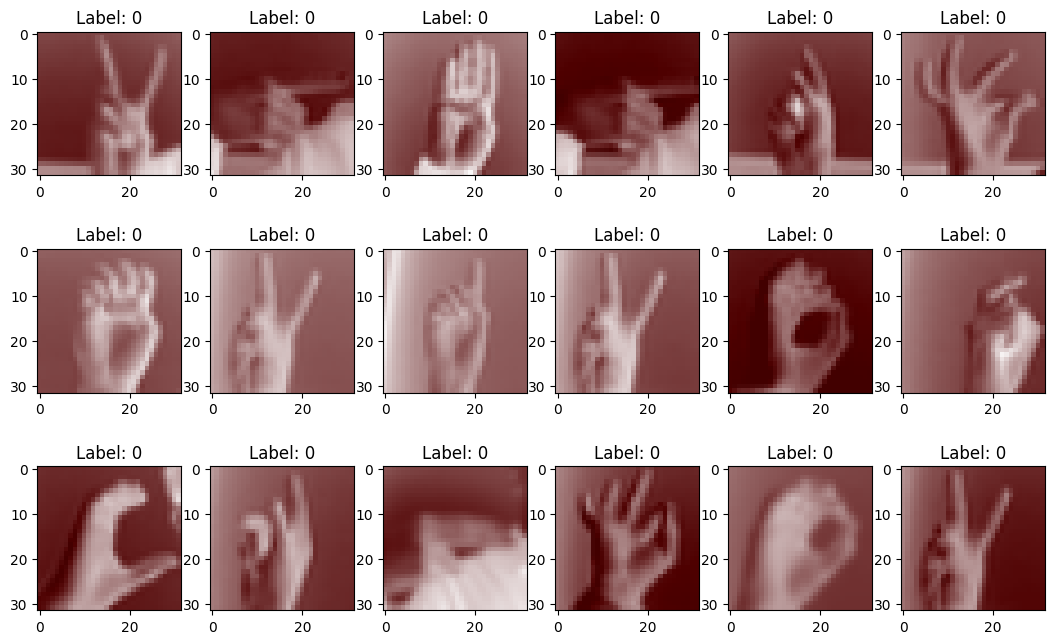

In [34]:
# Read todo, make sure the l"abels also didn't include 9
todo_data = read_tensor_dataset(
    "data/thws-mai-idl-ss-25-sign-language/SignLanguage_kaggle/todo.pth")

tod_dataset = SignLanguageDataset(
    todo_data)

todo_dataloader = iter(DataLoader(tod_dataset))

img, label = next(todo_dataloader)
print(img.shape)

plot_dataset(todo_dataloader)

# Compute normalize parameter

In [35]:
def compute_mean_std(loader, n_channels=1):

    # n_channels = 1  # 如果是灰度图，改成1
    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)
    total_pixels = 0

    for images, _ in tqdm.tqdm(loader):
        # 如果是灰度图像，images.shape = (B, 1, H, W)
        # 如果是彩色图像，images.shape = (B, 3, H, W)
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)  # [B, C, H*W]
        total_pixels += images.size(2) * batch_samples

        mean += images.sum(dim=[0, 2])  # sum over batch and pixels
        std += (images ** 2).sum(dim=[0, 2])

    mean /= total_pixels
    std = (std / total_pixels - mean ** 2).sqrt()

    return mean, std


train_mean, train_std = compute_mean_std(train_dataloader)
print(train_mean, train_std)

100%|█████████▉| 19199/19218 [00:03<00:00, 4898.14it/s]

tensor([0.3992]) tensor([0.1779])


In [26]:
# test data
todo_mean, todo_std = compute_mean_std(todo_dataloader, 3)
print(todo_mean, todo_std)

100%|█████████▉| 7010/7029 [00:00<00:00, 30028.10it/s]

tensor([0.5339, 0.3282, 0.3282]) tensor([0.1378, 0.1967, 0.1967])


In [27]:
from utils import save_imgs
# create dataset for autoencoder
raw_imgs, _ = raw_data[:]
print(raw_imgs.shape)

todo_ex_imgs, _ = todo_example[:]

todo_imgs, _ = todo_data[:]
print(todo_imgs.shape)
todo_imgs = torch.concat([todo_ex_imgs, todo_imgs], dim=0)

print(todo_imgs.shape)

last_id = save_imgs(todo_imgs, "data/auto_encoder_imgs/todo", 0)
last_id = save_imgs(raw_imgs[:len(todo_imgs)],
                    "data/auto_encoder_imgs/train", last_id)

torch.Size([27455, 3, 28, 28])
torch.Size([7029, 3, 32, 32])
torch.Size([7172, 3, 32, 32])
